### 1) Description of Maximum Cut

https://github.com/dwave-examples/maximum-cut

In this demo, we explore the maximum cut problem. This problem has a wide variety of real-world applications.

For example, suppose that we have a set of different computers, each with different types of connections. Some computers have bluetooth, some have USB ports, HDMI ports, etc. We want to split our set of computers into two groups for two different projects, but it's very important that the two groups can connect to each other. The problem is sometimes the wires and connections don't work! How can we be sure that we have the best chance at remaining connected?

One way to solve this problem is with the maximum cut problem. If we think of our set of computers as a graph (a node/vertex for each computer), and draw an edge between computers that can connect to each other, we have a model of our network. If we look for a maximum cut in our graph, then we are looking for a way to split the nodes into two groups so that there are as many edges as possible between the groups. In our computer set, this means that we have two groups with as many connections as possible between the two groups. Now if one connection goes down, we have many more to use! This way we have created a more resilient network by providing many redundant connections between groups in case one connection fails.

Below we see a simple network of five nodes and three different ways to split the set of nodes into two groups. The dashed edges in each graph highlight the cut edges.

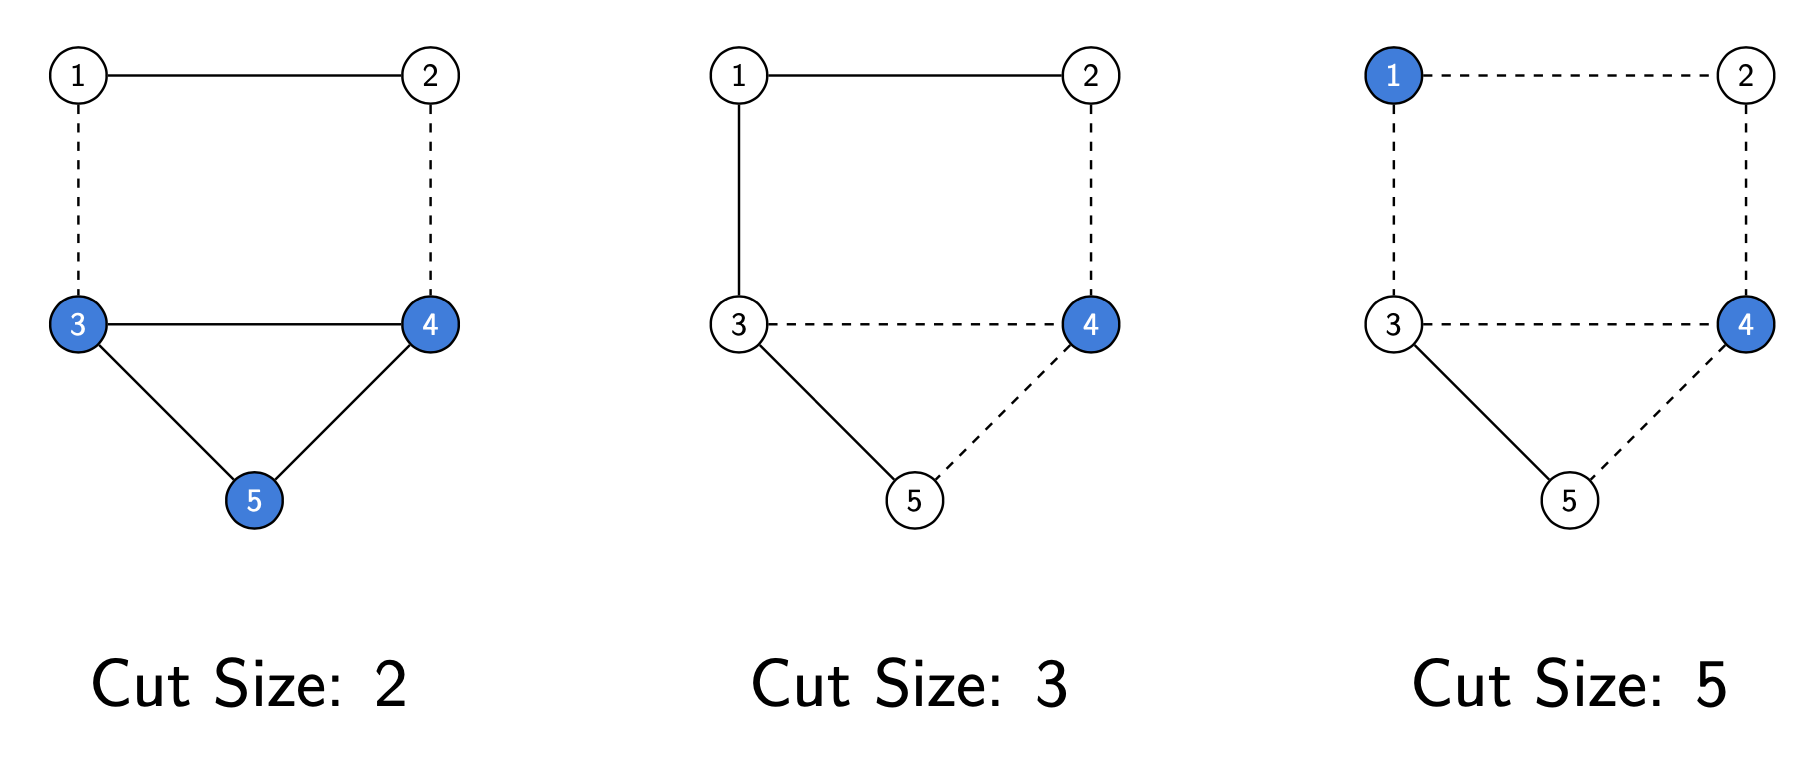

We will run the maximum cut problem on the network shown above to find the best way to split the network into two groups to maximize the number of cut edges.

### 2) Implementation

The code implements a QUBO formulation of this problem.

The answer that we are looking for is a partition of the nodes in the graph, so we will assign a binary variable for each node, i.e. variable x_i denotes whether node i is in one subset (call it Subset 0) or the other (Subset 1).

The objective function that we are looking to optimize is maximizing the number of cut edges. To count how many cut edges we have given a partition of the nodes (assignment of our binary variables), we consider a single edge in a graph in the table below. We only want to count an edge if the endpoints are in different subsets, and so we assign a 1 for the edge_score column in this case and a 0 otherwise.

| x_i   | x_j   | edge_score (i,j) |
| :---: | :---: | :---------------:|
| 0     | 0     | 0                |
| 0     | 1     | 1                |
| 1     | 0     | 1                |
| 1     | 1     | 0                |

From this table, we see that we can use the expression x_i+x_j-2x_ix_j to
calculate the edge_score column in our table.  Now for our entire graph, our
objective function can be written as shown below, where the sum is over all
edges in the graph.

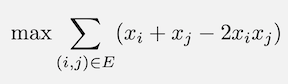

Since our system is used to minimize an objective function, we must convert this
maximization problem to a minimization problem by multiplying the expression by
-1.  Our final QUBO expression is the following.

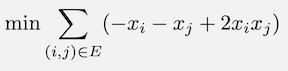

For the graph shown above, this QUBO results in the following Q matrix.  In the
Q matrix (implemented as a dictionary using Ocean), we put the coefficients on
the linear terms in our QUBO along the diagonal and the quadratic terms on the
off-diagonal.

|     | x_0 | x_1 | x_2 | x_3 | x_4 |
|:---:|:---:|:---:|:---:|:---:|:---:|
| x_0 | -2  | 2   | 2   | 0   | 0   |
| x_1 | 0   | -2  | 0   | 2   | 0   |
| x_2 | 0   | 0   | -3  | 2   | 2   |
| x_3 | 0   | 0   | 0   | -3  | 2   |
| x_4 | 0   | 0   | 0   | 0   | -2  |

In the code, we create this Q matrix as a dictionary iteratively, looping over
the edges in our graph just as we see in the summation of our QUBO expression.

Sampling if performed few times - defined by number of reads.  Since this is a small problem, we set a low number of reads
(shown with `reads_count = 100`).

### 3) Code

#### 3.1) Imports

In [1]:
import pandas as pd

import networkx as nx

from collections import defaultdict

from matplotlib import pyplot as plt

plt.style.use("dark_background")

from dimod import SimulatedAnnealingSampler

# from neal.sampler import SimulatedAnnealingSampler

In [2]:
# !pip install dimod

#### 3.2) Graph

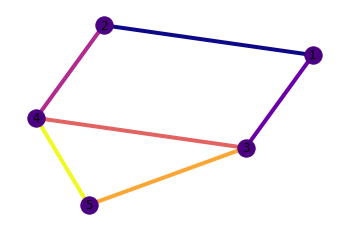

In [3]:
EDGES = [(1, 2), (1, 3), (2, 4), (3, 4), (3, 5), (4, 5)]

# Create empty graph
graph = nx.Graph()

# Add edges to the graph (also adds nodes)
graph.add_edges_from(EDGES)

# Node coordinates
positions = nx.kamada_kawai_layout(graph)

# Edge color range
edge_colors = range(graph.number_of_edges())

# Do not draw plot frame
plt.axis('off')

# Draw
nx.draw_networkx(G=graph, 
                 pos=positions, 
                 # with_labels=False, 
                 edge_cmap=plt.cm.plasma, 
                 edge_color=edge_colors,
                 # node_size=0,
                 node_color='indigo',
                 width=4)

#### 3.3) Create QUBO

In [4]:
# Initialize our QUBO dictionary
QUBO = defaultdict(int)

# Update QUBO dictionary for every edge in the graph
for i, j in graph.edges:
    
    QUBO[(i, i)] += -1
    QUBO[(j, j)] += -1
    QUBO[(i, j)] += 2

#### 3.4) Sample QUBO

In [5]:
# Number of Simulated Annealing reads
reads_count = 100

# Create Sampler
sampler = SimulatedAnnealingSampler()

# Sample QUBO with Sampler
results = sampler.sample_qubo(QUBO, num_reads=reads_count)

# Aggregate results
aggregated_results = results.aggregate()

print(aggregated_results)

   1  2  3  4  5 energy num_oc.
0  1  0  0  1  0   -5.0      27
1  0  1  1  0  1   -5.0      18
2  0  1  1  0  0   -5.0      25
3  1  0  0  1  1   -5.0      20
4  0  0  1  1  0   -4.0       1
5  1  1  0  0  1   -4.0       3
6  0  1  1  1  0   -4.0       2
7  1  0  0  0  1   -4.0       1
8  1  0  1  1  0   -4.0       3
['BINARY', 9 rows, 100 samples, 5 variables]


#### 3.5) Printout Results

In [6]:
node_set_records = []

sample_energies = aggregated_results.data(fields=['sample', 'energy'])

for sample, energy in sample_energies:
    
    set_0_nodes = [node for node, bit in sample.items() if bit == 0]
    set_1_nodes = [node for node, bit in sample.items() if bit == 1]
    
    cut_size = -energy
    
    node_set_record = [set_0_nodes, set_1_nodes, energy, cut_size]
    
    node_set_records.append(node_set_record)

node_sets = pd.DataFrame(node_set_records, columns=['Set 0','Set 1','Energy','Cut Size'])

node_sets

,Set 0,Set 1,Energy,Cut Size
0,"[2, 3, 5]","[1, 4]",-5.0,5.0
1,"[1, 4]","[2, 3, 5]",-5.0,5.0
2,"[1, 4, 5]","[2, 3]",-5.0,5.0
3,"[2, 3]","[1, 4, 5]",-5.0,5.0
4,"[1, 2, 5]","[3, 4]",-4.0,4.0
5,"[3, 4]","[1, 2, 5]",-4.0,4.0
6,"[1, 5]","[2, 3, 4]",-4.0,4.0
7,"[2, 3, 4]","[1, 5]",-4.0,4.0
8,"[2, 5]","[1, 3, 4]",-4.0,4.0


#### 3.6) Next Level: Graph Partitioning

https://github.com/dwave-examples/graph-partitioning